# Breast Cancer Prediction (WDBC) using ANN  
**Objective:** Classify tumors as **Malignant** or **Benign** using the WDBC dataset with a deep ANN and interpretability techniques.


## 1. Imports & Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import shap

## 2. Load Data

In [11]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()
# In that case 'target' is numeric 0/1, and feature names in data.feature_names

# Quick check
print("Shape:", df.shape)
df.head()

Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Exploratory Data Analysis (EDA)

target
1    357
0    212
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_15512\3390703987.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="Set2")


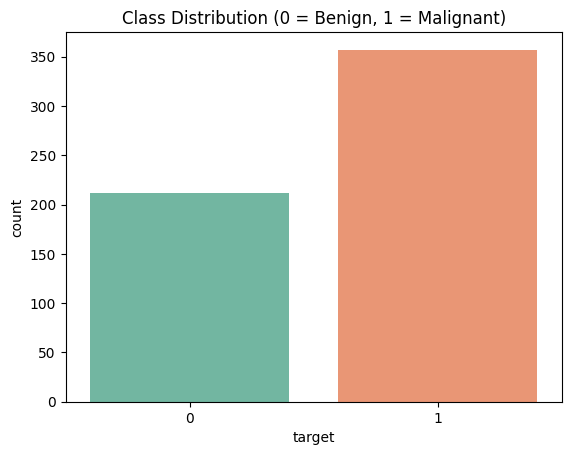

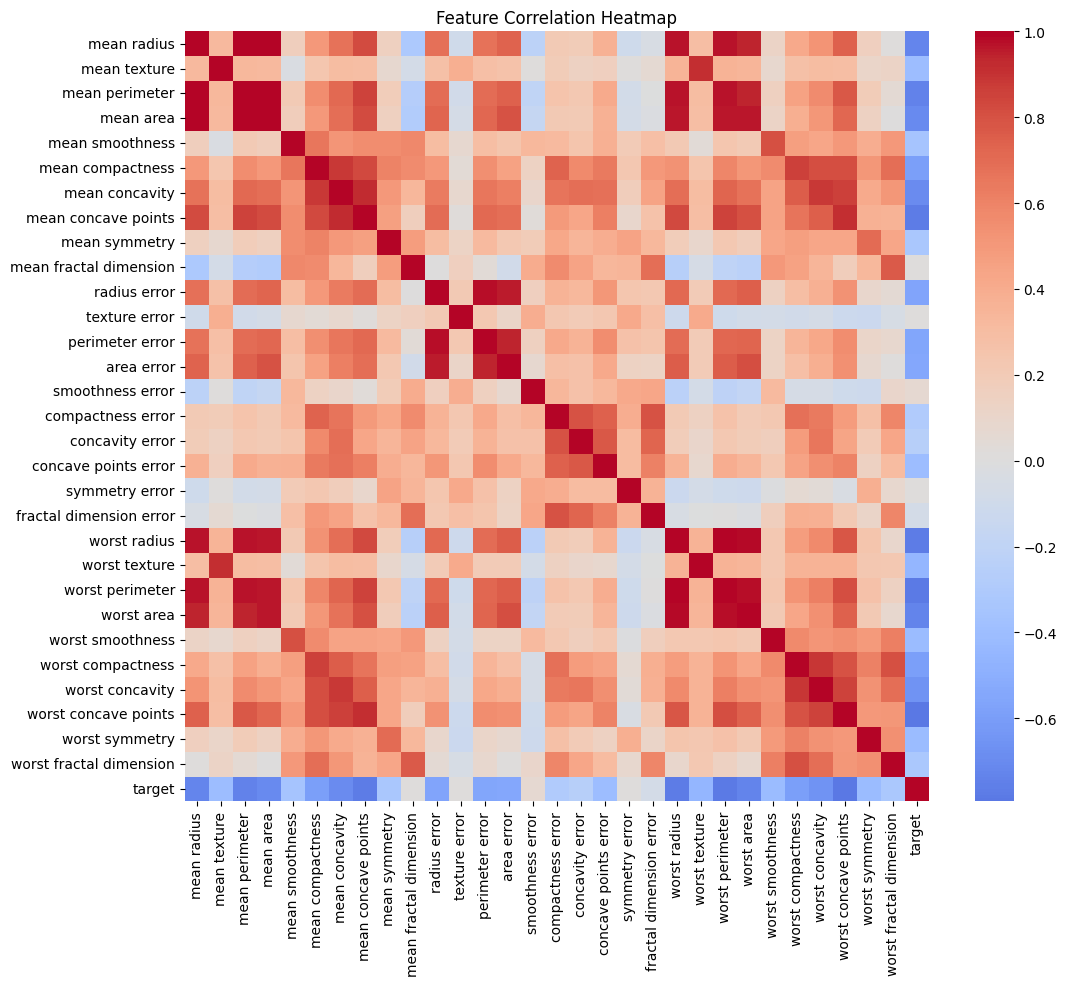

In [14]:
print(df['target'].value_counts())

## 3. Exploratory Data Analysis (EDA)
sns.countplot(x="target", data=df, palette="Set2")
plt.title("Class Distribution (0 = Benign, 1 = Malignant)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### Correlation Heatmap Analysis

From the correlation heatmap, we can observe several important patterns:

1. **High Inter-feature Correlations**: Many features are highly correlated with each other
2. **Feature Groups**: Features cluster into groups (mean, error, worst measurements)
3. **Target Relationships**: The target variable shows specific correlation patterns
4. **Multicollinearity**: Strong correlations suggest potential redundancy